# CIFAR10を用いた物体認識（ResNet）


---
## 目的

畳み込みニューラルネットワークのモデルとして，ResNetを用いて実験を行い，その構造を理解する．

## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [ ]:
# モジュールのインポート
from time import time
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: False


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
!from CenterLoss import CenterLoss
from torch.autograd.function import Function

import matplotlib.pyplot as plt

from: can't read /var/mail/CenterLoss


In [ ]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss

class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())

        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
        return - grad_output * diff / batch_size, None, grad_centers / batch_size, None

In [ ]:
def visualize(feat, labels, epoch):
    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    plt.clf()
    for i in range(10):
        plt.plot(feat[labels == i, 0], feat[labels == i, 1], '.', c=c[i])
    plt.legend(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], loc = 'upper right')
    #plt.figure(figsize=[8,8])
    plt.xlim(xmin=-2,xmax=2)
    plt.ylim(ymin=-2,ymax=2)
    plt.text(-4,4,"epoch=%d" % epoch)
    # plt.savefig('./images/epoch=%d.jpg' % epoch)
    plt.draw()
    plt.pause(0.001)

## データセットの読み込みと確認

学習データ（CIFAR10データセット）を読み込みます．

In [ ]:
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=1),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transform_train, download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


## Residual Networks (ResNet)
Residual Networks (ResNet) は，2015年のILSVRCの優勝モデルです．
VGGNet[2]で示されたように，ネットワークを深くすることは表現能力を向上させ，認識精度を改善できます．
しかし，あまりにも深いネットワークは効率的な学習が困難でした．

ResNetは，通常のネットワークのように，何かしらの処理ブロックによる変換$F(x)$を単純に次の層に渡していくのではなく，
スキップ構造によりその処理ブロックへの入力$x$をショートカットし， $H(x) = F(x)+x$を次の層に渡すようにしています．
スキップ構造により，誤差逆伝播時に勾配が消失しても，層をまたいで値を伝播することができます．
このショートカットを含めた処理単位をResidual blockと呼びます．
スキップ構造により非常に深いネットワークにおいても効率的に学習ができるようになりました．
Residual blockは，3×3 のフィルタサイズを持つ畳み込み層とBatch Normalization，ReLUから構成されています．

深いネットワークでは，ある層のパラメータの更新によって，その次の層への入力の分布がバッチ毎に大きく変化してしまう内部共変量シフト (Internal covariate shift) が発生し，学習が効率的に進まない問題がありました．
Batch Normalizationは，内部共変量シフトを正規化し，なるべく各層が独立して学習を行えるようにすることで，学習を安定化・高速化する手法です．
ResNetでは，このBatch Normalizationとスキップ構造をResidual blockに組み込むことで非常に深いネットワークの学習を実現しています．

<img src="https://drive.google.com/uc?export=view&id=1ZXQ7P-MwGjhrS64yIsYQ8OnclV6nPEUq" width = 100%>

### Basic BlockとBottleneck
Residual BlockにはBasic BlockとBottleneckと呼ばれる2種類のResidual blockの構造があります．
Basic Blockは3x3の畳み込みを二つ用いた構造となっており，比較的浅いResNet（ResNet-18や34など）使用されます．
一方，Bottleneckは1×1, 3×3, 1×1の3つの畳み込みを用いた構造となっており，一度チャンネル数を削減して畳み込みを行い，再度元のチャンネル数に戻すという処理を行っています．Bottleneck構造は深いResNet（ResNet-50, 101, 152など）に用いられます．
この2つの構造は同等の計算コストですが，BottleNeck型を採用することで精度を保持しながら計算効率化もできるというメリットがあります．

![BasicBlockBottleNeck](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/143078/a642b5c5-ec42-1705-72ab-2911bb82f97e.png)


### ImageNet版ResNetとCIFAR10/100版ResNetの違い
ImageNet版ResNetとCIFAR10/100版ResNetの違いについては，本ノートブックの下部に記述していますので，興味のある方はご確認ください．

## ネットワークモデルの定義

Residual Network (ResNet) を定義します．

### Residual Block (Basic BlockとBottleneck) の定義
まずはじめに，2種類のResidual Block（BasicBlockとBottleneck）を定義します．
ここでは，`BasicBlock(nn.Module)`および`Bottleneck(nn.Module)`で，任意の形の構造（チャンネル数など）を定義できるクラスを作成します．
`__init__`関数の引数である，`inplanes`は入力される特徴マップのチャンネル数，`planes`はBottleNeck内の特徴マップのチャンネル数を指定します．
また，`stride`はResidual Block内の1つ目の3x3の畳み込み層のstrideの値です．
`downsample`は，Residual Blockに入力された特徴マップサイズと畳み込み演算後の特徴マップのサイズが異なる場合に元の特徴マップ (resudual) のサイズを調整するための演算を定義するための引数です（詳細は後述）．

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.convs(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual                 #スキップ結合
        out = self.relu(out)
        return out

"""
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion * planes),
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.convs(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out"""

'\nclass Bottleneck(nn.Module):\n    expansion = 4\n    def __init__(self, in_planes, planes, stride=1, downsample=None):\n        super().__init__()\n        self.convs = nn.Sequential(\n            nn.Conv2d(in_planes, planes, kernel_size=1, bias=False),\n            nn.BatchNorm2d(planes),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),\n            nn.BatchNorm2d(planes),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False),\n            nn.BatchNorm2d(self.expansion * planes),\n        )\n        self.downsample = downsample\n        self.relu = nn.ReLU(inplace=True)\n        self.stride = stride\n\n    def forward(self, x):\n        residual = x\n        out = self.convs(x)\n        if self.downsample is not None:\n            residual = self.downsample(x)\n        out += residual\n        out = self.relu(out)\n        return out'

### ResNetの定義
上で定義したResidual Blockを活用して，ResNetを定義します．
ここでは，使用するResidual Blockの種類に応じて，`ResNetBasicBlock`と`ResNetBottleneck`の2種類のResNetを定義します．

`__init__()`内の`depth`は構築したいResNetの層数を指定します（20, 44, 110など）．
また，`n_class`はデータセットに応じて，クラス数を指定します．
`__init__()`内では，まずはじめに入力された`depth`がResNetを構築することができる数になっているかを確認します．
ResNetには，一番最初に単一の畳み込み層と出力層（全結合層）があります．
そのため，これら2つの層とResidual Block内の畳み込み層の数の合計が全体の層数となります．
また，Residual Blockは特徴マップのサイズに応じて，大きく3つのブロックから構成されています．
そのため，ResNetの層数は
$$(Res. Block内の畳み込みの数) * (1ブロックあたりのResidual Blockの数) * 3 + 2$$
となります．
そのため，BasicBlockを用いる際の層数は$6n+2$，Bottleneckを用いる際の層数$9n+2$となります（$n$は1ブロックあたりのResidual Blockの数）．

`self._make_layer()`は，任意の形（層数）のResidual Blockからなる層を定義します．
Residual Blockに入力されるチャンネル数`planes`，BottleNeckの数`n_blocks`，畳み込みのストライド`stride`を指定します．
その後，それらの引数に従い，指定した数・パラメータのBasickBlockまたはBottleneckをリスト内に格納します．
最後に，`nn.Sequential`を用いて一塊の層として定義し，任意の数の層を持つresidual blockを定義します（[nn.Sequentialについて](#note)）．

このとき，入力される特徴マップのサイズと畳み込み後（残差を計算する際）の特徴マップのサイズが異なる場合に，特徴マップのサイズを調整する`downsample`を定義します．
具体的には，特徴マップのサイズを調整することができるstrideで1x1の畳み込みを適用することで，マップのサイズを合わせます．
この`downsample`は，調整する必要がある場合に，`BasicBlock`および`Bottleneck`の引数として入力し，活用します．

In [ ]:
x = torch.randn(4,4)
print(x)
x = x.view(x.size(0), -1)
x

tensor([[-0.3558,  1.4736, -0.2156, -1.6004],
        [ 1.3398,  0.8079, -0.9071,  1.4493],
        [-0.1793,  1.7503, -0.3211, -1.6085],
        [ 0.7184,  0.8682,  0.8597, -0.0818]])


tensor([[-0.3558,  1.4736, -0.2156, -1.6004],
        [ 1.3398,  0.8079, -0.9071,  1.4493],
        [-0.1793,  1.7503, -0.3211, -1.6085],
        [ 0.7184,  0.8682,  0.8597, -0.0818]])

In [ ]:
class ResNetBasicBlock(nn.Module):
    def __init__(self, depth, n_class=10):
        super().__init__()
        # 指定した深さ（畳み込みの層数）でネットワークを構築できるかを確認
        assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2 (e.g. 20, 32, 44).'
        n_blocks = (depth - 2) // 6  # 1ブロックあたりのBasic Blockの数を決定

        self.inplanes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, n_blocks)
        self.layer2 = self._make_layer(32, n_blocks, stride=2)
        self.layer3 = self._make_layer(64, n_blocks, stride=2)

        self.avgpool = nn.AvgPool2d(8)

        self.ip1 = nn.Linear(64, 2)           #追加
        self.fc = nn.Linear(64 * BasicBlock.expansion, n_class, bias=False)

        #self.ip2 = nn.Linear(2, 10, bias=False)    #追加  ここでいうip2は，2行上のfcに該当するのでいらない

    def _make_layer(self, planes, n_blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * BasicBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * BasicBlock.expansion),
            )

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * BasicBlock.expansion
        for _ in range(0, n_blocks - 1):
            layers.append(BasicBlock(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)  #スキップする間のブロックのこと？
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)   #x.size(0)は行数

        ip1 = self.relu(self.ip1(x))  #可視化用？
        x = self.fc(x)
        return ip1, F.log_softmax(x, dim=1)
        #return ip1, x

"""
class ResNetBottleneck(nn.Module):
    def __init__(self, depth, n_class=10):
        super().__init__()
        # 指定した深さ（畳み込みの層数）でネットワークを構築できるかを確認
        assert (depth - 2) % 9 == 0, 'When use Bottleneck, depth should be 9n+2 (e.g. 47, 56, 110, 1199).'
        n_blocks = (depth - 2) // 9  # 1ブロックあたりのBasic Blockの数を決定

        self.inplanes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, n_blocks)
        self.layer2 = self._make_layer(32, n_blocks, stride=2)
        self.layer3 = self._make_layer(64, n_blocks, stride=2)

        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * Bottleneck.expansion, n_class)

    def _make_layer(self, planes, n_blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for _ in range(0, n_blocks - 1):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x"""

"\nclass ResNetBottleneck(nn.Module):\n    def __init__(self, depth, n_class=10):\n        super().__init__()\n        # 指定した深さ（畳み込みの層数）でネットワークを構築できるかを確認\n        assert (depth - 2) % 9 == 0, 'When use Bottleneck, depth should be 9n+2 (e.g. 47, 56, 110, 1199).'\n        n_blocks = (depth - 2) // 9  # 1ブロックあたりのBasic Blockの数を決定\n\n        self.inplanes = 16\n\n        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)\n        self.bn1 = nn.BatchNorm2d(16)\n        self.relu = nn.ReLU(inplace=True)\n\n        self.layer1 = self._make_layer(16, n_blocks)\n        self.layer2 = self._make_layer(32, n_blocks, stride=2)\n        self.layer3 = self._make_layer(64, n_blocks, stride=2)\n\n        self.avgpool = nn.AvgPool2d(8)\n        self.fc = nn.Linear(64 * Bottleneck.expansion, n_class)\n\n    def _make_layer(self, planes, n_blocks, stride=1):\n        downsample = None\n        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:\n            downsample = nn.S

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．
使用したいResdual Block構造の種類に応じて，層数を指定します．

CNNクラスを呼び出して，ネットワークモデルを定義します． 
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します． 
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD (モーメンタム付き確率的勾配降下法) を利用します． 
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．

In [ ]:
# ResNetの層数を指定 (e.g. 20, 32, 44, 47, 56, 110, 1199)
n_layers = 20

# ResNetを構築
model = ResNetBasicBlock(depth=n_layers, n_class=10)    # BasicBlock構造を用いる場合
# model = ResNetBottleneck(depth=n_layers, n_class=10)  # Bottleneck構造を用いる場合

if use_cuda:
    model.cuda()

device = torch.device("cuda" if use_cuda else "cpu")

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## 学習
１回の誤差を算出するデータ数（ミニバッチサイズ）を128，学習エポック数を100とします．
CIFAR10の学習データサイズを取得し，１エポック内における更新回数を求めます．
学習モデルに`image`を与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベル`label`との誤差をsoftmax coross entropy誤差関数で算出します．
また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [ ]:
x = [[3,5,7],[2,2,2]]

y, z = x
z

[2, 2, 2]

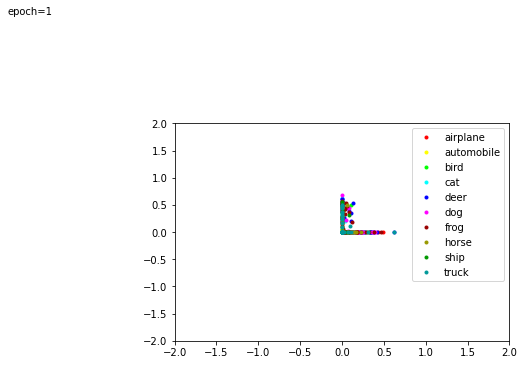

epoch: 1, mean loss: 1.9437096859741212, mean accuracy: 0.41208, elapsed_time :419.43975925445557


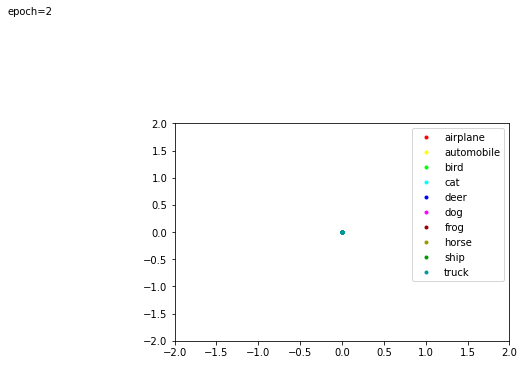

epoch: 2, mean loss: 1.0977748510742187, mean accuracy: 0.6144, elapsed_time :847.9658970832825


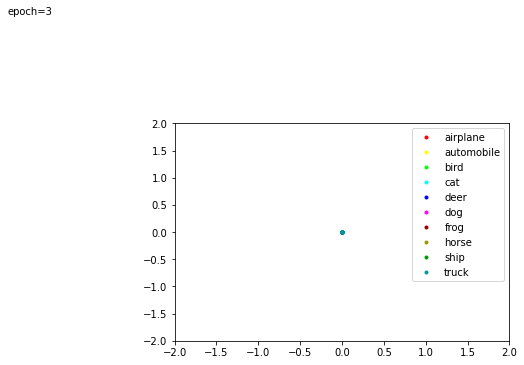

epoch: 3, mean loss: 0.8557777565002441, mean accuracy: 0.69844, elapsed_time :1266.7644941806793


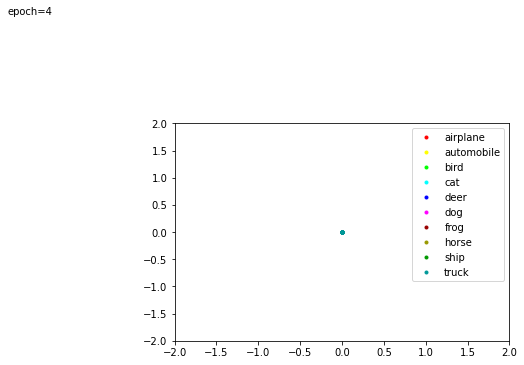

epoch: 4, mean loss: 0.72758219581604, mean accuracy: 0.74482, elapsed_time :1696.488914012909


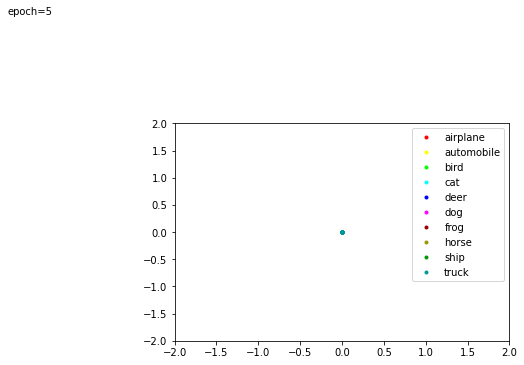

epoch: 5, mean loss: 0.6594474535369873, mean accuracy: 0.77206, elapsed_time :2118.7942020893097


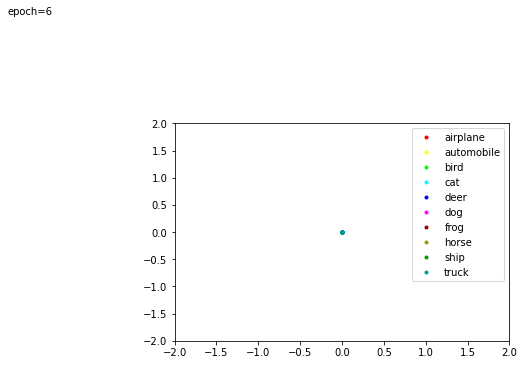

epoch: 6, mean loss: 0.6152853937530518, mean accuracy: 0.7862, elapsed_time :2547.612184047699


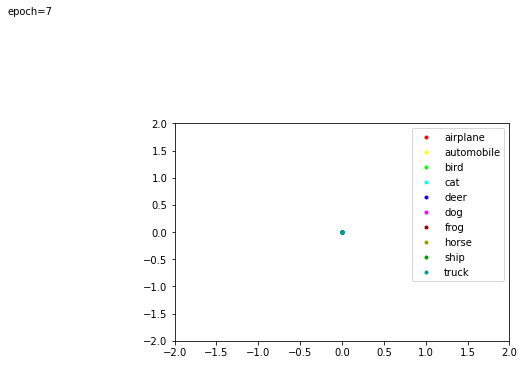

epoch: 7, mean loss: 0.5902202055358887, mean accuracy: 0.79616, elapsed_time :2970.8704283237457


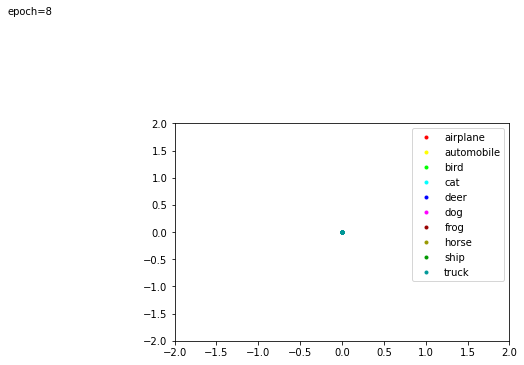

epoch: 8, mean loss: 0.5625159552001953, mean accuracy: 0.80636, elapsed_time :3396.0399236679077


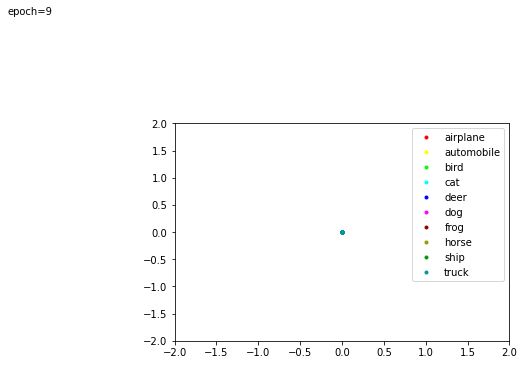

epoch: 9, mean loss: 0.5468899757385254, mean accuracy: 0.81342, elapsed_time :3819.715447664261


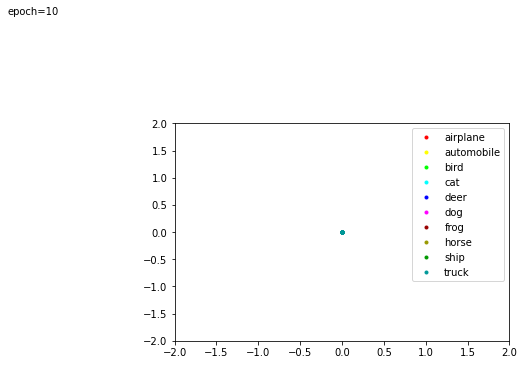

epoch: 10, mean loss: 0.5351035726928711, mean accuracy: 0.8164, elapsed_time :4243.998844861984


In [ ]:
# ミニバッチサイズ・エポック数の設定
batch_size = 128
epoch_num = 10
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)


"""
"""

# NLLLoss
nllloss = nn.NLLLoss().to(device) #CrossEntropyLoss = log_softmax + NLLLoss
# CenterLoss
loss_weight = 1
centerloss = CenterLoss(10, 2).to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
#optimizer4center = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimzer4center = optim.SGD(centerloss.parameters(), lr =0.5)


"""
"""


# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()



start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0

    ip1_loader = []
    idx_loader = []

    for image, label in train_loader:
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        ip1, y = model(image)
        #loss = criterion(y, label)
        loss = nllloss(y, label) + loss_weight * centerloss(label, ip1)

        model.zero_grad() #計算した勾配を初期化 どっち？
        #optimizer.zero_grad()

        optimzer4center.zero_grad()

        loss.backward() #勾配を計算
        optimizer.step()
        optimzer4center.step()

        ip1_loader.append(ip1)
        idx_loader.append((label))
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

    feat = torch.cat(ip1_loader, 0)
    labels = torch.cat(idx_loader, 0)
    visualize(feat.data.cpu().numpy(),labels.data.cpu().numpy(),epoch)
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))

## テスト
学習したネットワークモデルを用いて評価を行います．

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        ip1, y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / len(test_data)))

## 課題


### 1. 学習の設定を変更し，認識精度の変化を確認しましょう．

**ヒント：プログラムの中で変更で切る設定は次のようなものが存在します．**
* ミニバッチサイズ
* 学習回数（Epoch数）
* 学習率
* 最適化手法
  * `torch.optim.Adagrad()`や`torch.optim.Adam()`などが考えられます．
  * PyTorchで使用できる最適化手法は[こちらのページ](https://pytorch.org/docs/stable/optim.html#algorithms)にまとめられています．


### 2. Data Augmentationの種類を追加して学習を行いましょう．

**ヒント**
：学習時に使用するData Augmentationは`transform_train`の部分で変更できます．

```python
transform_train = transforms.Compose([(この部分に使用するAugmentationの処理を追加) ,
                                      transforms.ToTensor(),
                                      transforms.LinearTransformation(Z, mean)])
```

PyTorch（torchvision）で使用可能な変換は[こちらのページ](https://pytorch.org/vision/stable/transforms.html)にまとめられています．


## 備考
<a id='note'></a>

### nn.Sequential()について
また，層を定義する`__init__`内では，`nn.Sequential()`という関数が用いられています．
これは，複数の層が格納されたリストを引数として受け取り，これらの層をひとまとめにしたオブジェクト（層）を定義する関数です・
下の関数では，畳み込みやBatchNormalizationがリスト内にされています．
`nn.Sequential`で定義した層`self.convs`では，実際に演算する際，すなわち`formward()`関数内では，`self.convs(x)`とすることで，リストに格納した演算をその順番通りに処理して返すことができます．

### ImageNet版ResNetとCIFAR10/100版ResNetの違い
このノートブックで実装したResNetは，ResNetの元論文でCIFAR10/100の分類実験に使用された構造を定義しています．
ResNetには大きく，ImageNet版とCIFAR版があり，今日広く用いられているモデルはImageNet版となります．
ImageNetとCIFAR版の主な違いは以下の通りです．

|                   | ImageNet | CIFAR |
|-------------------|----------|-------|
| 1層目の畳み込みのカーネルサイズ | 7x7 | 3x3 |
| 1層目の畳み込み後の特徴マップチャンネル数 | 64 | 16 |
| 複数のRes. Blockを統合したブロックの数 | 4 | 3 |
| 各ブロック内のRes. Blockの数 | 構造・ブロックによって異なる | `(層数 - 2) // 6` (Basicblock) または `(層数 - 2) // 9` (BottleNeck) |

ImageNet版のResNetは`torchvision.models`に実装されており，学習済みモデルなども公開されています（[torchvisionのResNetリファレンスページ](https://pytorch.org/vision/stable/models.html#id10)）．